In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, SAGEConv, NNConv, GCNConv
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec

torch.manual_seed(42)

In [124]:
%run dataset_nc_per_modeltype.ipynb

Processing...
Done!


DATASET LOADED: USE per_model variable !!!
EnterpriseModelDatasetNCPerModeltype(110)


In [125]:
dataset_nc_per_modeltype[0].y

tensor([ 1,  1, 35, 29,  1,  1,  1,  1, 29, 29, 33, 29,  9, 29,  1,  1, 13, 29,
        13, 27, 27, 27,  1, 29,  1, 29, 29,  1, 12,  1, 29,  9,  1,  1, 29, 29,
         1, 33, 34, 34])

In [126]:
per_model["info"]

{'Goal Model': 6,
 'Actors and Resources Model': 11,
 'Product-Service-Model': 4,
 'Business Rule & Process Model': 12,
 '4EM General Model': 7,
 'Goal & Business Rule Model': 7,
 'Business Process Model': 43,
 'Concepts Model': 10,
 'Technical Components and Requirements Model': 10}

In [127]:
# use only business process models
bpms = per_model["data"]["Business Process Model"]

print(f'Number of graphs total: {len(bpms)}')
print(bpms[1].y)

Number of graphs total: 43
tensor([ 1, 29,  1,  1, 29, 29, 29, 12, 12,  1,  1, 29,  1, 12,  1,  1, 29,  9,
        29, 12,  1, 29, 13, 19,  1, 29, 29,  1, 33,  1, 29,  9,  1,  1,  1, 29])


In [128]:
bpm_node_classes = []

for graph in bpms:
    for nclass in graph.y:
        bpm_node_classes.append(nclass.item())
    
bpm_node_classes = list(set(bpm_node_classes))
print(bpm_node_classes)

new_node_classes = []
map_old_to_new_node_class = {}

for i, old_index in enumerate(bpm_node_classes):
    new_node_classes.append(node_classes[old_index])
    map_old_to_new_node_class[old_index] = i
    
    
print(new_node_classes)
print(map_old_to_new_node_class)

[1, 33, 35, 9, 12, 13, 19, 29]
['Information Set', 'Join (OR)', 'Join (AND)', 'Split (OR)', 'Comment', 'Split (AND)', 'External Process', 'Process']
{1: 0, 33: 1, 35: 2, 9: 3, 12: 4, 13: 5, 19: 6, 29: 7}


In [129]:
for graph in bpms:
    for i, nclass in enumerate(graph.y):
        graph.y[i] = map_old_to_new_node_class[nclass.item()]

In [130]:
len(bpms)

43

In [131]:
NUM_GRAPHS_PER_BATCH = len(bpms)
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(bpms, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [132]:
x = []
edge_index = []
edge_attr = []
y = []
train_mask = []
test_mask = []
for batch in train_loader:
    x = batch.x
    edge_index = batch.edge_index
    edge_attr = batch.edge_attr
    y = batch.y
    train_mask = batch.train_mask
    test_mask = batch.test_mask

    
data = Data(x=x, 
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            train_mask=train_mask,
            test_mask=test_mask
            ) 

num_nodes = data.x.shape[0]
print(data)

Data(x=[835, 1], edge_index=[2, 836], edge_attr=[836, 1], y=[835], train_mask=[835], test_mask=[835])


In [134]:
values, counts = np.unique(data.y, return_counts=True)
values, counts

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([367,  15,  14,  41,  33,  27,  30, 308], dtype=int64))

!!! stark unbalanciert
367 Information Sets, 308 Processes, und nur 160 von den anderen Klassen
    -> Testen, wie sich entwickelt, wenn nur Prozesse und Information Sets trainiert und getestet werden

Epoch: 01, Loss: 2.0890, Acc: 0.3761


C:\Users\alber\anaconda3\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\alber\anaconda3\envs\pyg_env\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


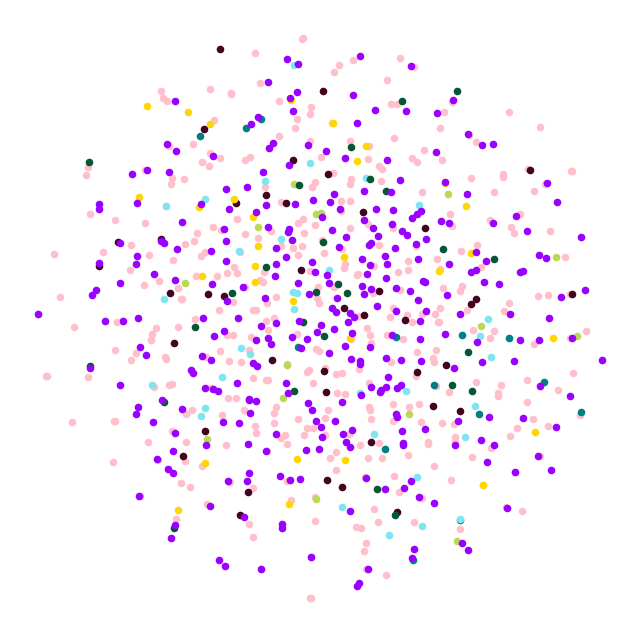

In [135]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=16, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

num_workers = 1
loader = model.loader(batch_size=32, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

for epoch in range(1, 2):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(len(new_node_classes)):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700', '#9900ff', '#008080', '#420420', '#7fe5f0', '#065535',
    '#008080', '#420420', '#7fe5f0', '#ff00ff', '#993366', '#ff5050',
    '#ff9933', '#ffff66', '#ffffcc', '#0066cc', '#00cc66', '#333300',
    '#996600', '#99ff66', '#cc99ff', '#336699', '#33cc33', '#339966',
    '#cc9900', '#66ff66', '#6666ff', '#009999', '#666699', '#ffcccc',
]
plot_points(colors)

In [106]:
z = model()
z[0]

tensor([ 0.1896, -0.2857, -0.1463,  0.2405, -0.1143, -0.0413, -0.1885, -0.0563,
        -0.3704,  0.0011,  0.2796, -0.1334, -0.1844, -0.4163,  0.1368,  0.1909],
       grad_fn=<SelectBackward0>)

In [52]:
data.x.shape

Data(x=[835, 1], edge_index=[2, 836], edge_attr=[836, 1], y=[835], train_mask=[835], test_mask=[835])

In [107]:
x = []
edge_index = []
edge_attr = []
y = []
train_mask = []
test_mask = []
for batch in train_loader:
    x = z
    edge_index = batch.edge_index
    edge_attr = batch.edge_attr
    y = batch.y
    train_mask = batch.train_mask
    test_mask = batch.test_mask

    
data = Data(x=x, 
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            train_mask=train_mask,
            test_mask=test_mask
            ) 

num_nodes = data.x.shape[0]
print(data)

Data(x=[835, 16], edge_index=[2, 836], edge_attr=[836, 1], y=[835], train_mask=[835], test_mask=[835])


Nun kann ein Modell mit den gelernten Embeddings der Nodes gelernt werden

In [108]:
dataset = data
dataset.y

tensor([7, 7, 0, 6, 0, 7, 0, 0, 0, 5, 7, 0, 7, 0, 0, 7, 0, 6, 0, 7, 7, 0, 0, 7,
        0, 3, 0, 7, 7, 7, 7, 0, 0, 7, 2, 0, 7, 0, 0, 7, 0, 6, 0, 7, 0, 0, 3, 7,
        7, 0, 0, 5, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 7, 0, 7, 0, 0, 6, 4, 7, 7, 0,
        5, 0, 0, 2, 7, 0, 4, 0, 7, 7, 4, 0, 7, 0, 3, 7, 3, 0, 0, 7, 4, 7, 7, 0,
        7, 7, 0, 0, 0, 6, 3, 4, 4, 7, 4, 7, 0, 7, 7, 0, 7, 7, 7, 0, 0, 0, 7, 7,
        7, 3, 0, 1, 0, 0, 0, 0, 7, 2, 0, 7, 0, 0, 7, 0, 6, 0, 7, 0, 0, 3, 7, 7,
        0, 0, 5, 7, 0, 0, 7, 0, 7, 0, 0, 3, 7, 0, 0, 7, 0, 0, 5, 7, 7, 0, 0, 0,
        5, 7, 7, 7, 5, 7, 0, 0, 0, 7, 1, 0, 0, 0, 0, 0, 7, 7, 7, 7, 0, 4, 7, 1,
        0, 7, 3, 7, 0, 7, 7, 7, 0, 0, 0, 7, 7, 7, 7, 3, 1, 0, 0, 0, 7, 0, 7, 7,
        0, 0, 7, 0, 7, 0, 0, 7, 0, 7, 0, 3, 7, 0, 7, 7, 0, 0, 3, 7, 0, 0, 3, 0,
        0, 0, 0, 3, 2, 7, 0, 0, 7, 0, 0, 0, 5, 7, 7, 7, 5, 7, 0, 7, 4, 7, 7, 7,
        0, 7, 0, 0, 7, 7, 5, 0, 0, 0, 0, 0, 0, 7, 3, 0, 0, 0, 7, 7, 1, 7, 0, 7,
        7, 5, 0, 0, 0, 2, 4, 7, 7, 7, 7,

In [111]:
class GATGNN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(dataset.num_node_features, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv2 = GATConv(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv3 = GATConv(4 * NUM_HIDDEN_CHANNELS, len(new_node_classes), heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, len(new_node_classes))

        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.elu(self.conv1(x, edge_index, edge_attr) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_attr) + self.lin2(x))
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        return F.log_softmax(x, dim=1)

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN2().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GATGNN2(
  (conv1): GATConv(16, 64, heads=4)
  (lin1): Linear(in_features=16, out_features=256, bias=True)
  (conv2): GATConv(256, 64, heads=4)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 8, heads=6)
  (lin3): Linear(in_features=256, out_features=8, bias=True)
)
Number of parameters:  156880


In [113]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

In [ ]:
@torch.no_grad()
def test():
    model.eval()

    total_acc = 0
    for data in train_loader:
        pred = model(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
        total_acc += acc * data.num_graphs
    return total_acc / len(train_loader.dataset)

In [ ]:
loss_values = []
acc_values = []

for epoch in range(1, 2):
    loss = train()
    acc = test()
    
    loss_values.append(loss)
    acc_values.append(acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Acc: {acc:.4f},')
    

plt.plot(loss_values, 'r',)
plt.show()
plt.plot(acc_values, 'b',)
plt.show()